In [ ]:
import os
os.chdir('/content/drive/MyDrive/FGSM/')

In [ ]:
!ls

data  fgsm.ipynb  lenet_mnist_model.pth


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# inputs
epsilon = [0,.05,.1,.15,.2,.25,.3]
pretrained_model = '/content/drive/MyDrive/FGSM/lenet_mnist_model.pth'
use_cuda = True

In [ ]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
# FGSM attack code
def fgsm_attack(image,epsilon,data_grad): 
  data_grad_sign = data_grad.sign()  # Collect the element-wise sign of the data gradient
  #____1
  perturbed_image = image - epsilon * data_grad_sign  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = torch.clamp(perturbed_image,0,1) # Adding clipping to maintain [0,1] range
  
  return perturbed_image # Return the perturbed image

In [ ]:
def test(model,device,test_loader,epsilon):
  c = 0 # accuracy counter
  count = 0 
  adv_ex = []
  #_____2
  targetx = torch.tensor([1],device=device)  # desired target
  for data,target in test_loader: # Loop over all examples in test set
    data,target = data.to(device),target.to(device) # Send the data and label to the device
    data.requires_grad = True # Set requires_grad attribute of tensor. Important for Attack
    output = model(data) # Forward pass the data through the model
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    #_____3
    if init_pred.item() != target.item() or target.item() == targetx.item():# If the initial prediction is wrong, dont bother attacking, just move on
      continue
    #_____4
    loss = F.nll_loss(output,targetx) # Calculate the loss
    model.zero_grad() # Zero all existing gradients
    loss.backward() # Calculate gradients of model in backward pass
    data_grad = data.grad.data # Collect datagrad

    perturbed_image = fgsm_attack(data,epsilon,data_grad)# Call FGSM Attack
    
    output = model(perturbed_image) # Re-classify the perturbed image
    final_pred = output.max(1,keepdim = True)[1]
    if final_pred.item() == targetx.item():
        count += 1
    # Check for success
    if final_pred.item() == target.item():
      c += 1
      if (epsilon == 0) and (len(adv_ex) < 5 ): # Special case for saving 0 epsilon examples
        adv_example = perturbed_image.squeeze().detach().cpu().numpy()
        adv_ex.append((init_pred.item(),final_pred.item(),adv_example))
    else:
      if final_pred.item() == targetx.item() and (len(adv_ex) < 5): # Save some adv examples for visualization later
        adv_example = perturbed_image.squeeze().detach().cpu().numpy()
        adv_ex.append((init_pred.item(),final_pred.item(),adv_example))
        
  final_acc = c/float(len(test_loader))# Calculate final model test accuracy for this epsilon
  print("Epsilon: {}\tModel Test Accuracy = {} / {} = {}".format(epsilon, c, len(test_loader), final_acc))
  

  return final_acc,adv_ex # Return the accuracy and an adversarial example

In [ ]:
accuracy = []
example = []
for e in epsilon: # Run test for each epsilon
 final_acc,adv_ex = test(model,device,test_loader,e)
 accuracy.append(final_acc)
 example.append(adv_ex)


Epsilon: 0	Model Test Accuracy = 8684 / 10000 = 0.8684
Epsilon: 0	attack conf val = 0 / 10000 = 0.0
************
Epsilon: 0.05	Model Test Accuracy = 8567 / 10000 = 0.8567
Epsilon: 0.05	attack conf val = 23 / 10000 = 0.0023
************
Epsilon: 0.1	Model Test Accuracy = 8211 / 10000 = 0.8211
Epsilon: 0.1	attack conf val = 120 / 10000 = 0.012
************
Epsilon: 0.15	Model Test Accuracy = 7252 / 10000 = 0.7252
Epsilon: 0.15	attack conf val = 399 / 10000 = 0.0399
************
Epsilon: 0.2	Model Test Accuracy = 5383 / 10000 = 0.5383
Epsilon: 0.2	attack conf val = 935 / 10000 = 0.0935
************
Epsilon: 0.25	Model Test Accuracy = 3059 / 10000 = 0.3059
Epsilon: 0.25	attack conf val = 1678 / 10000 = 0.1678
************
Epsilon: 0.3	Model Test Accuracy = 1300 / 10000 = 0.13
Epsilon: 0.3	attack conf val = 2354 / 10000 = 0.2354
************


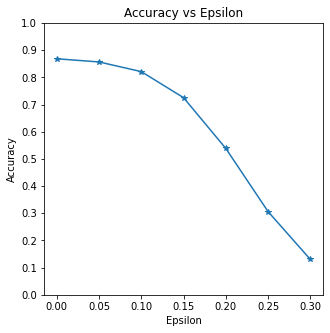

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilon, accuracy, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

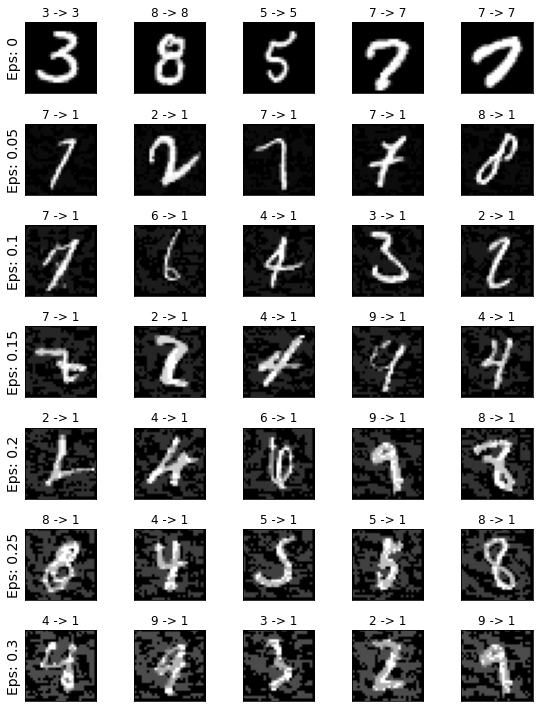

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilon)):
    for j in range(len(example[i])):
        cnt += 1
        plt.subplot(len(epsilon),len(example[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilon[i]), fontsize=14)
        orig,adv,ex = example[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()